<a href="https://colab.research.google.com/github/joony0512/Deep_Learning_Class/blob/main/Part8/P8_Ch05_CH03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Super Resolution 학종이만한사진 확대하기
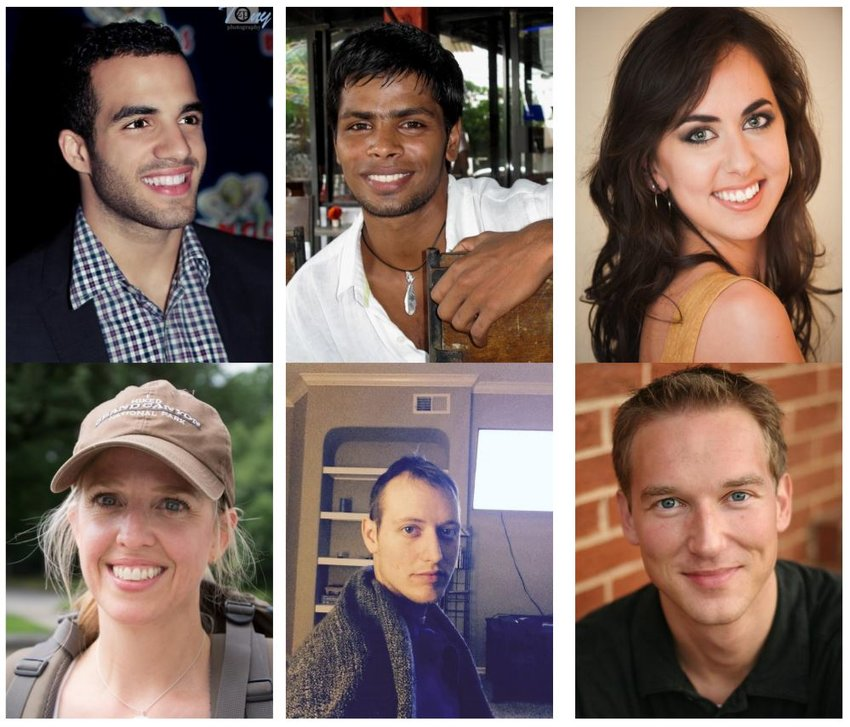

위의 이미지는 다음과 같은 것을 보여줍니다.  
- 800x600의 사람 portrait 이미지  
    - ?????.png  
- 사람 영역에 대한 흑백 portrait 이미지
    - ?????_matte.png
- pfcn_original
    - 원본 800x600 이미지들.
- pfcn_small
    - colab용 100x75 이미지들



- 데이터 출처:
 - [PFCN dataset](https://1drv.ms/u/s!ApwdOxIIFBH19Ts5EuFd9gVJrKTo)

 - [pfcn_small](https://drive.google.com/file/d/1_q37TRIFwtwhmSeLu_4h3SkFHrDSjeyl/view?usp=sharing)


## 최종목표
- 큰사진 작게 줄이기
- 작게 줄인 PFCN데이터를 이용해 사람 영역 추출
- 이미지에 대한 오토인코더식 접근 방법

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

SEED = 34

# 1. EDA, 데이터 구축

In [3]:
!ls -al /content/drive/MyDrive/딥러닝_정주행/pfcn_original/testing/??001.png

-rw------- 1 root root 753417 Oct  7  2016 /content/drive/MyDrive/딥러닝_정주행/pfcn_original/testing/00001.png


In [4]:
import imageio
x = imageio.imread('/content/drive/MyDrive/딥러닝_정주행/pfcn_original/training/00001.png')

In [5]:
x.shape

(800, 600, 3)

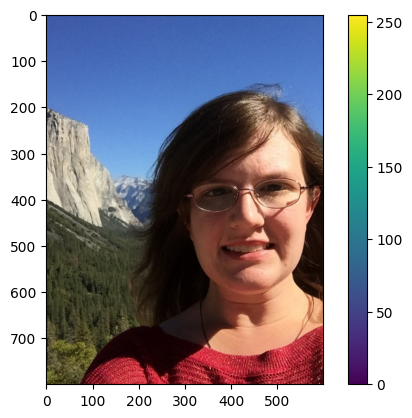

In [6]:
# pfcn original
plt.imshow(x)
plt.colorbar()
plt.show()

In [7]:
# pfcn original : (800, 600, 3) 너무 크기 떄문에 -> train_big : (200, 150, 3)으로 축소해서 사용 할것임

from skimage.transform import resize
x = resize(x, (200, 150, 3))

In [8]:
x.shape

(200, 150, 3)

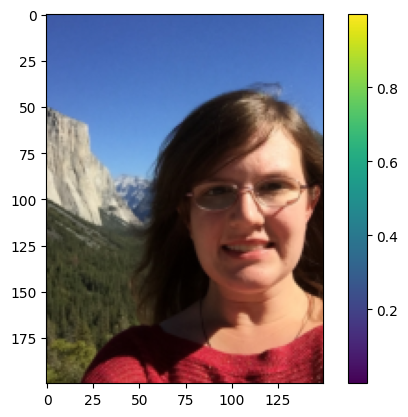

In [9]:
plt.imshow(x)
plt.colorbar()
plt.show()

- resize -> normalize 가 자동으로 처리됨


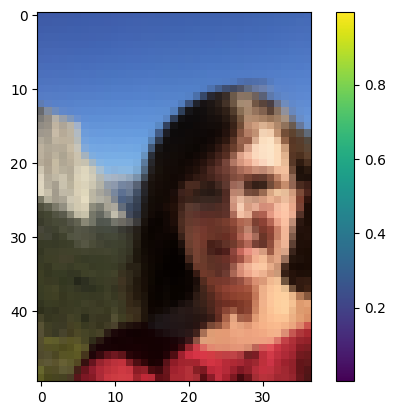

In [10]:
# train_small : (50, 37, 3)으로 축소해서 사용할것임

from skimage.transform import resize
x = resize(x, (50, 37, 3))
plt.imshow(x)
plt.colorbar()
plt.show()

In [54]:
# train_big : (200, 150, 3)으로 변경
# train_small data : (50, 37, 3)으로 변경
import os
import imageio
train_path = "/content/drive/MyDrive/딥러닝_정주행/pfcn_original/training"

# training 내 모든 .png 파일에 대해 이미지 크기 변경 후 배열에 추가(mattes파일 제외)
train_big_images = np.array([resize(imageio.imread(os.path.join(train_path, x)), (200, 150, 3)) for x in os.listdir(train_path) if x.endswith('.png')and 'matte' not in x])

# train_big_images의 shape 확인
print(train_big_images.shape)


(1700, 200, 150, 3)


In [55]:
train_small_images = np.array([resize(img, (50, 37, 3)) for img in train_big_images])

In [56]:
test_path = "/content/drive/MyDrive/딥러닝_정주행/pfcn_original/testing"

# testing 내 모든 .png 파일에 대해 이미지 크기 변경 후 배열에 추가(mattes파일 제외)
test_big_images = np.array([resize(imageio.imread(os.path.join(test_path, x)), (200, 150, 3)) for x in os.listdir(test_path) if x.endswith('.png')and 'matte' not in x])

# test_big_images의 shape 확인
print(test_big_images.shape)

(300, 200, 150, 3)


In [57]:
test_small_images = np.array([resize(img, (50, 37, 3)) for img in test_big_images])

In [58]:
train_big_images.dtype

dtype('float64')

In [59]:
output_path = "/content/drive/MyDrive/딥러닝_정주행/pfcn_original/resized"

# 디렉토리가 존재하지 않으면 생성
if not os.path.exists(output_path):
    os.makedirs(output_path)

# train_big_images 배열을 저장
np.savez(os.path.join(output_path, "train_big_images.npz"), train_big_images)
np.savez(os.path.join(output_path, "train_small_images.npz"), train_small_images)
np.savez(os.path.join(output_path, "test_big_images.npz"), test_big_images)
np.savez(os.path.join(output_path, "test_small_images.npz"), test_small_images)


In [60]:
train_big_images[train_big_images !=0][:10]

array([0.71951457, 0.71951457, 0.71951457, 0.71964908, 0.71964908,
       0.71964908, 0.72084384, 0.72084384, 0.72084384, 0.72169807])

In [61]:
train_small_images[train_small_images !=0][:10]

array([0.72483604, 0.72483604, 0.72483604, 0.72961713, 0.72961713,
       0.72961713, 0.73354324, 0.73354324, 0.73354324, 0.73724137])

In [62]:
train_big_images.dtype, train_small_images.dtype

(dtype('float64'), dtype('float64'))

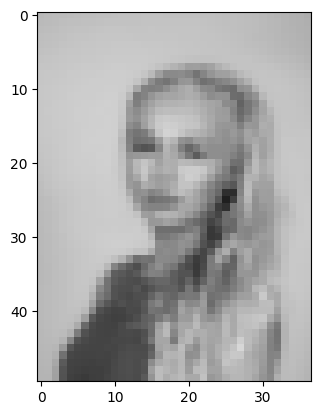

In [63]:
# small data
plt.imshow(train_small_images[0])

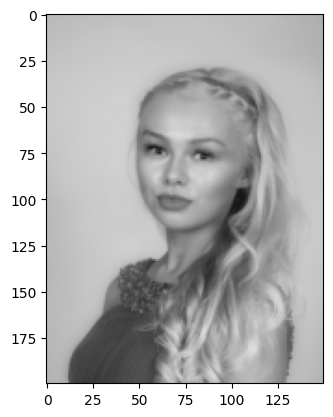

In [64]:
# big data
plt.imshow(train_big_images[0])

# 2. 전처리

In [65]:
# 데이터 범위 확인
print(train_big_images[train_big_images >1.0][:10])
print(train_big_images[train_big_images >0.9][:10])
print(train_big_images[train_big_images < 0.0][:10])

[]
[0.9051065  0.90914237 0.90071585 0.90130396 0.91375769 0.91713748
 0.92395084 0.92869773 0.93095833 0.92941199]
[]


In [66]:
train_big_images.max(), train_big_images.min()

(1.0, 0.0)

In [67]:
test_big_images.max(), test_big_images.min()

(1.0, 0.0)

# 3. 시각화

In [68]:
train_big_images[:5].shape

(5, 200, 150, 3)

In [69]:
# big : (200, 150*5, 3)로 shape로 변경

five_train_big = train_big_images[:5].transpose((1, 0, 2, 3)).reshape((200, -1, 3))
five_train_big.shape

(200, 750, 3)

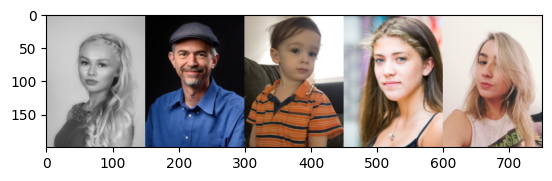

In [70]:
plt.imshow(five_train_big)

In [73]:
# small (50, 137*5, 3)로 shape로 변경

five_train_small = train_small_images[:5].transpose((1, 0, 2, 3)).reshape((50, -1, 3))
five_train_small.shape

(50, 185, 3)

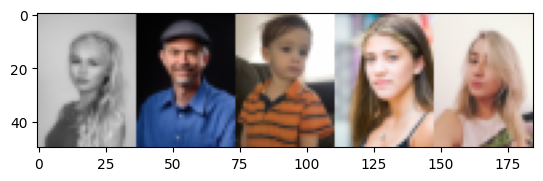

In [74]:
plt.imshow(five_train_small)